# Exercise 5: Variational Quantum Eigensolver (VQE)

### 1. Importing standard libraries

In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

### 2. Getting the molecule ready -> Li-H

A `driver` is an interface to the classical chemistry codes available in Qiskit. 
By running a driver, we obtain necessary information about our molecule, to then apply `VQE` 


In [2]:
from qiskit_nature.drivers import PySCFDriver

# The representation of Li-H molecule
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

# Gives an idea regarding which orbitals can be freezed and removed
print(qmolecule.one_body_integrals)  

[[-4.73853724  0.10753914  0.1675853   0.          0.         -0.03026284
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10753914 -1.51317577  0.03434669  0.          0.         -0.06802917
   0.          0.          0.          0.          0.          0.        ]
 [ 0.1675853   0.03434669 -1.12916229  0.          0.          0.03143223
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.14077094  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.14077094  0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.03026284 -0.06802917  0.03143223  0.          0.         -0.9418187
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -4.73853724  0.10753914  0.1675853   0.          0.    

In [3]:
print("Number of molecular orbitals: ", qmolecule.num_molecular_orbitals)
print("Number of spin-orbitals: ", 2*qmolecule.num_molecular_orbitals)
print("Nuclear repulsion energy: ", qmolecule.nuclear_repulsion_energy)

Number of molecular orbitals:  6
Number of spin-orbitals:  12
Nuclear repulsion energy:  1.0259348796432726


### 3. Ferminonic Operators

The `ElectronicStructureProblem` produces a list of fermionic operators (Pauli strings) for the molecule.
The `FreezeCoreTransformer` is a transformer in Qiskit-nature that is used to freeze inner core orbitals and remove unoccupied molecular orbitals.  

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer

# Freeze the inner core and remove orbitals 3,4 (one body integrals from the previous cell)
# The ElectronicStructureProblem produces a list of fermionic operators before mapping to Qubits
problem = ElectronicStructureProblem(driver, q_molecule_transformers=
                                     [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])])

# Generate the second quantized operators
second_q_ops = problem.second_q_ops()
# Get the Hamiltonian
main_op = second_q_ops[0]

# Modified one body integrals
print(problem.molecule_data_transformed.one_body_integrals) 

[[-0.78066411  0.04770212 -0.12958119  0.          0.          0.        ]
 [ 0.04770212 -0.35909729  0.06823803  0.          0.          0.        ]
 [-0.12958119  0.06823803 -0.22617115  0.          0.          0.        ]
 [ 0.          0.          0.         -0.78066411  0.04770212 -0.12958119]
 [ 0.          0.          0.          0.04770212 -0.35909729  0.06823803]
 [ 0.          0.          0.         -0.12958119  0.06823803 -0.22617115]]


### 4. Mapping to Qubits

`ParityMapper` is used to map the fermionic operators to qubit operators.
A `QubitConverter`object is used to reduce the qubits even further by exploiting the symmetries.

In [5]:
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction= [1])

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

# Fermionic operators are mapped to qubit operators
qubit_op = converter.convert(main_op, num_particles=num_particles)
print(qubit_op)

-0.20316606150558716 * IIII
- 0.3652586902160391 * ZIII
+ 0.09275994933497503 * IZII
- 0.2118898429700864 * ZZII
+ (0.3652586902160392-2.7755575615628914e-17j) * IIZI
- 0.11384335176464107 * ZIZI
+ 0.11395251883046094 * IZZI
+ (-0.060440128573164456-3.469446951953614e-18j) * ZZZI
+ (-0.09275994933497497+6.938893903907228e-18j) * IIIZ
+ 0.11395251883046094 * ZIIZ
+ (-0.12274244052543586+6.938893903907228e-18j) * IZIZ
+ 0.05628878167218207 * ZZIZ
+ (-0.21188984297008645+2.0816681711721685e-17j) * IIZZ
+ 0.060440128573164456 * ZIZZ
- 0.05628878167218208 * IZZZ
+ 0.0846013139182359 * ZZZZ
+ 0.019389408583692383 * XIII
+ (-0.019389408583692383-4.336808689942018e-19j) * XZII
+ (-0.010952773573813853+8.673617379884035e-19j) * XIZI
+ 0.010952773573813853 * XZZI
+ 0.012779333033031574 * XIIZ
- 0.012779333033031576 * XZIZ
- 0.009002501243838515 * XIZZ
+ 0.009002501243838515 * XZZZ
+ 0.0029411410873504597 * IXII
+ 0.0029411410873504597 * ZXII
- 0.01068185628295703 * IXZI
- 0.01068185628295703 * Z

### 5. Initial State

A CPU can compute efficiently the energies associated to electron hopping and interactions that represent the total energy operator, Hamiltonian, by means of `Hartree-Fock`. The `Hartree–Fock (HF)` method efficiently computes an approximate ground state wavefunction.

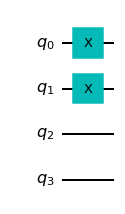

In [6]:
from qiskit_nature.circuit.library import HartreeFock

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw()

### 6. Exact Eigensolver

The problem can be exactly solved with the exact diagonalization of the Hamiltonian matrix. This helps us know where to converge with VQE, for learning purposes.

In [7]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [8]:
result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

# Exact electronic Energy is higher than actual energy due to
# the freezing of inner core orbitals

Exact electronic energy -1.0887060157347368


### 7. Ansatz

A `Heuristic (TwoLocal)` ansatz circuit is used to approximate the ground state wavefunction. The different parameters for the circuit are obtained by experimentation.

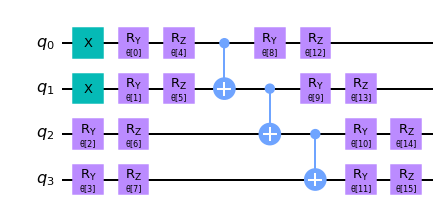

In [9]:
from qiskit.circuit.library import TwoLocal

ansatz_type = "TwoLocal"
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cx'
entanglement = "linear"
repetitions = 1
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions,
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)

# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)
ansatz.draw()

### 8. Backend

A backend is a device or simulator to run the algorithm. Here the `statevector_simulator` is used.

In [10]:
backend = Aer.get_backend('statevector_simulator')

### 9. Algorithm

The optimizer `SLSQP` with a `maxiter = 1000` is used. 
An `initial_point` is provided to the VQE, to start from a similar point.

In [11]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms import VQE

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
optimizer = SLSQP(maxiter= 1000)

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 786,
    'eigenstate': array([ 1.39131226e-03+1.62920545e-04j, -4.80344694e-03-1.47047592e-04j,
        2.62447729e-02+8.47628269e-04j, -9.91330355e-01+1.36767252e-02j,
       -5.37464440e-02-3.77350493e-03j, -3.69555386e-04-8.90731172e-05j,
        8.79307549e-04-4.46593915e-06j, -2.32783453e-02+1.49208704e-03j,
       -2.67397326e-03-7.05573705e-05j, -1.12127825e-05-8.31876644e-06j,
        3.67494259e-06+2.34900094e-05j,  3.09653242e-04-9.10944922e-04j,
        1.13571961e-01-2.69468702e-03j,  5.56021549e-04+1.40788574e-04j,
       -5.49346724e-04+3.83200142e-05j, -3.05785674e-05-1.92967062e-05j]),
    'eigenvalue': -1.0863472034410773,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -0.005426351911253571,
                              ParameterVectorElement(θ[13]): -0.04487184826402391,
                              ParameterVectorElement(θ[0]): 0.2521552078200679,
                              ParameterVe

### 10. Analysis

A `chemical accuracy = 4 mHa` is to be reached, with as minimum `CNOTs` as possible.

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,TwoLocal,4,16,"[ry, rz]",cx,linear,1,2.358812,True,3


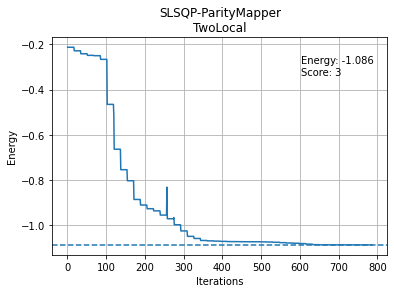

In [12]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

### 11. Results

The following results are obtained:
1. `Ansatz = TwoLocal`
2. `Optimizer = SLSQP`
3. `Number of qubits = 4`
4. `Number of parameters = 16`
5. `Error = 2.36 mHa`